# Import

In [1]:
# 基礎
import pandas as pd
import numpy as np
import math
import json
import os
import jieba  ## 斷字
jieba.set_dictionary('dict.txt.big')
stopwords = [ line.rstrip() for line in open('stop_words.txt' , encoding='utf8') ] ## 這個中文停用字典可以自己找

# 視覺化
import matplotlib.pyplot as plt  ## python最常見的繪圖工具
import matplotlib
zhfont1 = matplotlib.font_manager.FontProperties(fname='simsun.ttf')  ## plt中文字
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA  ## 降維視覺化常用工具
from pylab import rcParams  ## 調整畫布比例

# 訓練模型
from sklearn.model_selection import train_test_split  ## 切分鍊與測試資料集
from sklearn.neighbors import KNeighborsClassifier  ## KNN
from sklearn.svm import SVC  ## SVM
from  xgboost import XGBClassifier  ## xgboost
import xgboost

# 從新竹社會局常見問答集爬取
def getdata():
    with open('RawData.json', 'r', encoding='utf8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

c:\users\jeremy\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Preprocess

In [2]:
## crawled data may not have words and vector columns, and the id is categoryid
df_train = getdata()
print("Rows=", len(df_train))
df_train.head()

Rows= 327


,ans,cat,id,question
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？


In [3]:
# 斷字
def preprocess(question):
#     words = list(jieba.cut(question)) ## 精準模式
    words = list(jieba.cut(question, cut_all=True)) ## 全斷詞模式
    return words
df_train['words'] = df_train['question'].apply(preprocess)
df_train.head()

Building prefix dict from D:\Projects\ithome_ironman\day29_Classification_LineBot\dict.txt.big ...
Loading model from cache C:\Users\Jeremy\AppData\Local\Temp\jieba.u63456f9ae4a201225dc9817a9ebd7e54.cache
Loading model cost 1.970 seconds.
Prefix dict has been built succesfully.


,ans,cat,id,question,words
0,1.幼兒家長在戶政事務所完成新生兒出生登記後，即可向所轄區公所社政課提出育兒津貼申請。2.在...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, , ]"
1,隨時提出;津貼經審查通過後，追溯自受理申請之當月起發給。兒童出生後六十日內向戶政事務所完成出...,幼兒福利及托育服務,189,小孩出生後應於何時申請育兒津貼?,"[小孩, 出生, 後, 應於, 何時, 申請, 育兒, 津貼, , ]"
2,申請資料應備齊:(一)兒童之戶口名簿影本。(二)申請人之郵局存摺封面影本。(三)父母雙方身分...,幼兒福利及托育服務,189,育兒津貼申請應備文件為何?,"[育兒, 津貼, 申請, 應, 備, 文件, 為, 何, , ]"
3,一、育兒津貼補助對象：1.育有二足歲以下兒童。2.兒童之父母至少一方因育兒需要，致未能就業者...,幼兒福利及托育服務,189,若民眾夫妻雙方均失業，是否可申請家庭育兒津貼費用補助,"[若, 民, 眾, 夫妻, 雙方, 均, 失業, , , 是否, 可, 申請, 家庭, 育兒..."
4,育兒津貼補助對象，應符合下列規定：(一)育有二足歲以下兒童。(二)兒童之父母(或監護人)至少...,幼兒福利及托育服務,189,育兒津貼補助對象為何？,"[育兒, 津貼, 貼補, 補助, 對象, 為, 何, , ]"


In [4]:
# 為了訓練需要，將類別轉化為數字類別(1~11類)
cat_mapping = {}
for num, cat in enumerate(list(set(df_train['cat']))):
    cat_mapping[cat] = num
    
# 預測時，要將預測出的結果翻譯為原先的類別所使用
inversed_cat_mapping = {}
for cat, idx in cat_mapping.items():
    inversed_cat_mapping[idx] = cat

print(cat_mapping)
print(inversed_cat_mapping)

# {'國民年金': 1, '社區發展服務': 2, '社工專業服務': 11, '兒童少年及家庭福利': 3, '身心障礙者福利': 4, '家庭暴力及性侵害防治服務': 8, '婦女福利': 6, '幼兒福利及托育服務': 7, '人民團體及合作社場服務': 9, '社會救助': 5, '老人福利': 10, '志願服務': 0}
# {0: '志願服務', 1: '國民年金', 2: '社區發展服務', 3: '兒童少年及家庭福利', 4: '身心障礙者福利', 5: '社會救助', 6: '婦女福利', 7: '幼兒福利及托育服務', 8: '家庭暴力及性侵害防治服務', 9: '人民團體及合作社場服務', 10: '老人福利', 11: '社工專業服務'}

{'社會救助': 11, '志願服務': 1, '人民團體及合作社場服務': 0, '兒童少年及家庭福利': 2, '老人福利': 4, '家庭暴力及性侵害防治服務': 5, '幼兒福利及托育服務': 3, '身心障礙者福利': 6, '社區發展服務': 7, '婦女福利': 9, '社工專業服務': 10, '國民年金': 8}
{0: '人民團體及合作社場服務', 1: '志願服務', 2: '兒童少年及家庭福利', 3: '幼兒福利及托育服務', 4: '老人福利', 5: '家庭暴力及性侵害防治服務', 6: '身心障礙者福利', 7: '社區發展服務', 8: '國民年金', 9: '婦女福利', 10: '社工專業服務', 11: '社會救助'}


In [5]:
# 添加類別本身當作問題，以增強簡短問題的回答能力
print('Preprocess Length = ', len(df_train))

addedrow = []
for key, value in cat_mapping.items():
    row = {}
    words = list(jieba.cut(key, cut_all=False))
    row['words'] = words
    
    row = {'ans': None,
            'cat': key,
            'id': None,
            'question': key,
            'words':words
          }
    addedrow.append(row)
addeddf = pd.DataFrame(addedrow)
df_train = pd.concat([df_train, addeddf])
print('Processed Length = ', len(df_train))

# Preprocess Length =  327
# Processed Length =  339

Preprocess Length =  327
Processed Length =  339


# Data Description

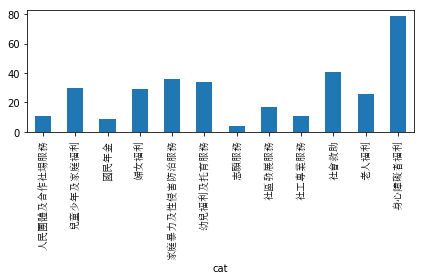

In [6]:
# 每個類別的問題個數
main_series = df_train.groupby('cat').count()['ans']
ax = main_series.plot(kind='bar')
ax.set_xticklabels(main_series.index, fontproperties=zhfont1)
plt.tight_layout()
# plt.savefig(os.path.join('pic', 'nums_of_queries_each_cat'))
plt.show()

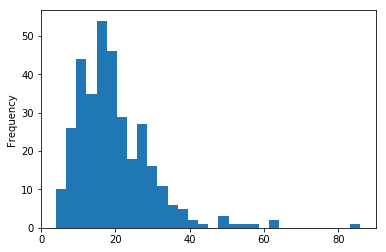

In [7]:
# 每個問題的長度
df_train['question'].apply(len).plot(kind='hist', bins=30)
# plt.savefig(os.path.join('pic', 'length_of_queries'))
plt.show()

人民團體及合作社場服務


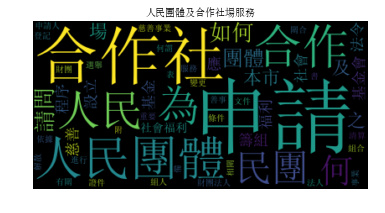

志願服務


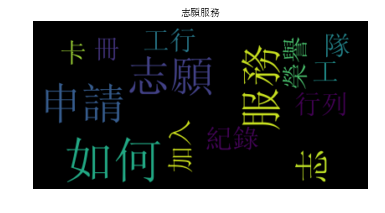

兒童少年及家庭福利


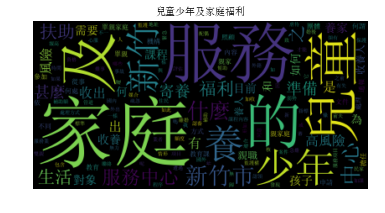

幼兒福利及托育服務


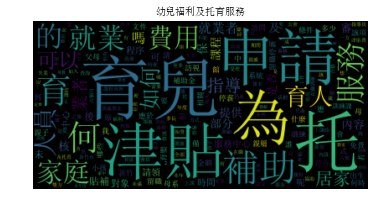

老人福利


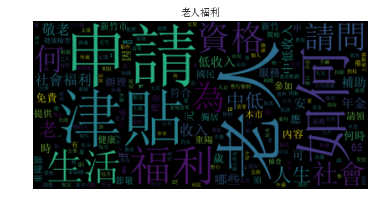

家庭暴力及性侵害防治服務


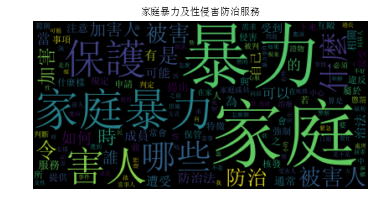

身心障礙者福利


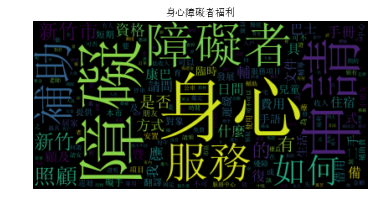

社區發展服務


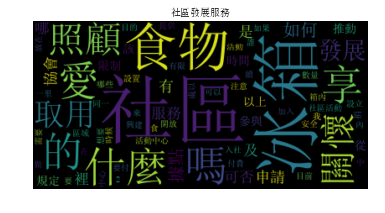

國民年金


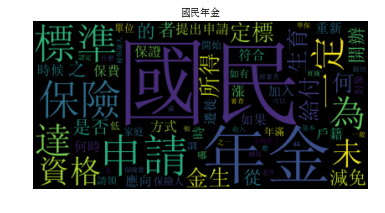

婦女福利


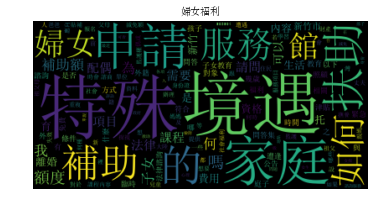

社工專業服務


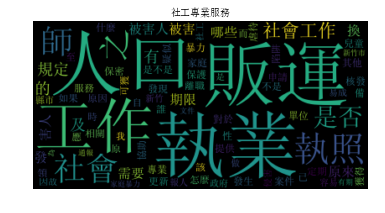

社會救助


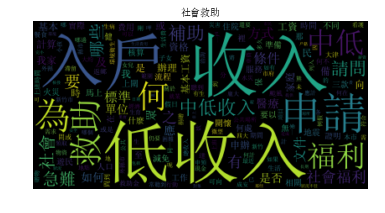

In [8]:
# 每個類別常出現的字
from wordcloud import WordCloud
from collections import Counter

freqs = []
for cat in list(set(df_train['cat'])):
    words_Li = list(df_train[df_train['cat'] == cat]['words'])
    total_words_in_cat = []
    for words in words_Li:
        total_words_in_cat.extend(words)
    freq = Counter(total_words_in_cat)
    print(cat)
    wordcloud = WordCloud(font_path="simsun.ttf")
    wordcloud.generate_from_frequencies(frequencies=freq)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(cat, fontproperties=zhfont1)
#     plt.savefig(os.path.join('pic', 'wordcloud_' + cat), bbox_inches='tight', pad_inches=0)
    plt.show()

# Prepare Training Data

In [13]:
# 準備排序的文字list(keywordindex)
total_li = []
for li in list(df_train['words']):
    total_li += li
vectorterms = list(set(total_li))

## 轉化每個問題變成向量
def vectorize(words):
    self_main_list = [0] * len(vectorterms)
    for term in words:
        if term in vectorterms:  ## 測試資料集當中的字不一訂有出現在訓練資料集中
            idx = vectorterms.index(term)
            self_main_list[idx] += 1
    return np.array(self_main_list)

X = np.concatenate(df_train['words'].apply(vectorize).values).reshape(-1, len(vectorterms))
Y = df_train['cat'].apply(cat_mapping.get)
print(X.shape)
print(Y.shape)

# (339, 1017)
# (339,)

(339, 1017)
(339,)


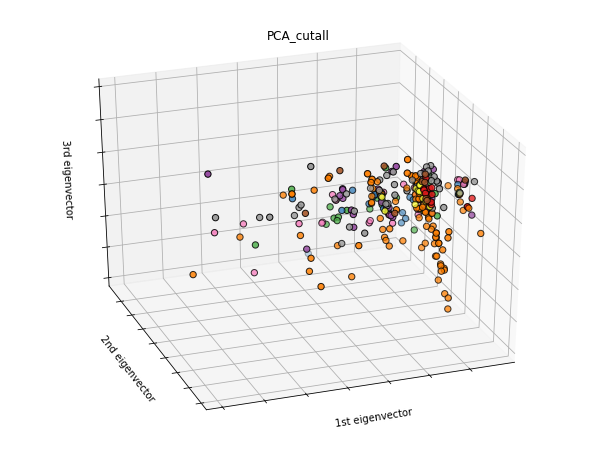

In [14]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA_cutall")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

# plt.savefig(os.path.join('pic', 'PCA_cutall'))
plt.show()

In [15]:
# Finally, we split some of the data off for validation
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=123)

print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

(271, 1017)
(68, 1017)
(271,)
(68,)


# Training

In [16]:
# 定義函式，輸入分類器，輸出準確率
def get_accuracy(clf, *args):
    if args:
        clf = clf(kernel=args[0])  ## SVM在這邊用Llinear比較準
    else:
        clf = clf()
    clf = clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_valid)
    return (str(sum(Y_valid == y_pred)/Y_valid.shape[0]))

print('KNN: ', get_accuracy(KNeighborsClassifier))
print('SVM_rbf: ', get_accuracy(SVC))
print('SVM_linear: ', get_accuracy(SVC, 'linear'))
print('XGB: ', get_accuracy(XGBClassifier))

# KNN:  0.602941176471
# SVM_rbf:  0.220588235294
# SVM_linear:  0.838235294118
# XGB:  0.897058823529

KNN:  0.617647058824
SVM_rbf:  0.220588235294
SVM_linear:  0.852941176471
XGB:  0.897058823529


In [17]:
params = {}
params['objective'] = 'multi:softmax'  ## 因為是多個類別，這邊跟前面兩個類別的使用不太一樣
params['eta'] = 0.1
params['max_depth'] = 3
params['silent'] = 1
params['nthread'] = 4
params['num_class'] = len(set(Y))  ## 多個類別，記得要告訴她有幾個類別

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-merror:0.151292	valid-merror:0.235294
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 100 rounds.
[10]	train-merror:0.118081	valid-merror:0.191176
[20]	train-merror:0.066421	valid-merror:0.132353
[30]	train-merror:0.051661	valid-merror:0.147059
[40]	train-merror:0.051661	valid-merror:0.132353
[50]	train-merror:0.04797	valid-merror:0.132353
[60]	train-merror:0.03321	valid-merror:0.117647
[70]	train-merror:0.02952	valid-merror:0.117647
[80]	train-merror:0.02583	valid-merror:0.117647
[90]	train-merror:0.01845	valid-merror:0.102941
[100]	train-merror:0.01476	valid-merror:0.102941
[110]	train-merror:0.01476	valid-merror:0.102941
[120]	train-merror:0.01107	valid-merror:0.102941
[130]	train-merror:0.00738	valid-merror:0.102941
[140]	train-merror:0.00738	valid-merror:0.102941
[150]	train-merror:0.00738	valid-merror:0.088235
[160]	train-merror:0.00738	valid-merror:0.088235
[170]	train-merror:0.00

In [18]:
y_pred = bst.predict(xgboost.DMatrix(X_valid))
print("Accuracy_valid: ", str(sum(Y_valid == y_pred)/Y_valid.shape[0]))
y_pred = bst.predict(xgboost.DMatrix(X))
print("Accuracy_all: ", str(sum(Y == y_pred)/Y.shape[0]))
# Accuracy_valid:  0.911764705882
# Accuracy_all:  0.976401179941

Accuracy_valid:  0.897058823529
Accuracy_all:  0.976401179941


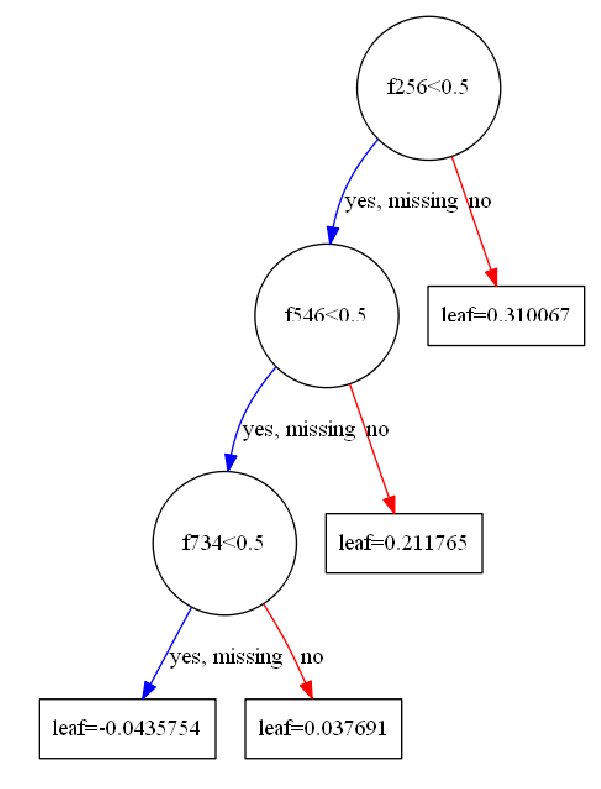

In [19]:
rcParams['figure.figsize'] = 10, 20
xgboost.plot_tree(bst, num_trees=2)
plt.savefig(os.path.join('pic', 'tree'), bbox_inches='tight', pad_inches=0)
plt.show()

# Prediction

In [20]:
# This is crawled from 台北社會局常見問答集
with open('Taipy_Society_Affiar_QA', 'r', encoding='utf8') as f:
    testing_questions = eval(f.read())
    testing_questions = np.random.choice(testing_questions, size=len(testing_questions))
    
df_test = pd.DataFrame(testing_questions, columns=['question'])
df_test.head()

,question
0,我最近看到臺北扶老.軟硬兼施廣告，請問那是什麼服務?怎樣的對象可以申請?
1,請問二代健保上路後會影響我的老人健保自付額補助資格嗎？
2,敬老、愛心悠遊卡可以借人使用嗎？
3,從哪裡可以得到老人福利服務資訊？\r\n
4,敬老、愛心及愛心陪伴悠遊卡，故障應備何文件重新辦理？


In [21]:
def predict(question):  ## 定義預測函數
    words = preprocess(question)
    vector = vectorize(words)
    cat_num = bst.predict(xgboost.DMatrix(vector.reshape(1, -1)))
    return inversed_cat_mapping.get(cat_num[0])
df_test['cat_pred'] = df_test['question'].apply(predict)
df_test[['question', 'cat_pred']]

,question,cat_pred
0,我最近看到臺北扶老.軟硬兼施廣告，請問那是什麼服務?怎樣的對象可以申請?,身心障礙者福利
1,請問二代健保上路後會影響我的老人健保自付額補助資格嗎？,老人福利
2,敬老、愛心悠遊卡可以借人使用嗎？,婦女福利
3,從哪裡可以得到老人福利服務資訊？\r\n,老人福利
4,敬老、愛心及愛心陪伴悠遊卡，故障應備何文件重新辦理？,老人福利
5,身心障礙者專用停車位識別證新制申請應備文件。,身心障礙者福利
6,「馬上關懷急難救助」經申請（或通報）後，何時可獲得協助？,社會救助
7,長者預防走失手鍊是否有GPS功能?,身心障礙者福利
8,「馬上關懷急難救助」向居住所在地或戶籍所在地申請？,社會救助
9,申請失能者生活輔助器具及居家無障礙環境改善補助應備文件為何？,身心障礙者福利


In [24]:
df_train_error = df_train[['question', 'cat']]
df_train_error['cat_pred'] = df_train_error['question'].apply(predict)
df_train_error.loc[df_train_error['cat'] != df_train_error['cat_pred'], ['question', 'cat', 'cat_pred']]

c:\users\jeremy\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,question,cat,cat_pred
31,如何查詢新竹巿親子館「新手父母教室」的課程內容及上課時間?如何報名,幼兒福利及托育服務,老人福利
182,我的小朋友好像有發展遲緩的狀況，該如何是好？,身心障礙者福利,老人福利
185,我的小朋友已經領有醫院發的發展遲緩評估報告書，接下來我該如何做？,身心障礙者福利,老人福利
284,誰容易成為人口販運被害人？,社工專業服務,家庭暴力及性侵害防治服務
285,政府對於人口販運被害人提供的協助有哪些?,社工專業服務,家庭暴力及性侵害防治服務
300,續食是什麼?,社區發展服務,身心障礙者福利
314,如何加入志工行列？,志願服務,老人福利
10,社工專業服務,社工專業服務,志願服務


In [26]:
query = input("請輸入你的問題?\n")
predict(query)

請輸入你的問題?
老人


'老人福利'